# Generate Molecular Structure Descriptors for a Zeolite

Nanoporous materials such as zeolites have pore dimensions similar to that of individual molecules and are used widely in industry as adsorbents, catalysts and chemical separation membranes. The nanoscale cavities in these materials serve as shape and size selective sites facilitating chemical reactions as well as storage, while the channels serve as molecular sieves that can be used for gas separations replacing energetically less efficient distillation processes. 

This notebook presents an approach outlined in [1] for generating computationally efficient digital representations of the molecular structure of nanoporous materials that are then used to compute a number of geometric and statistical descriptors for pore structures. The described methods are capable of identifying and labeling the transport relevant accessible regions in the porous crystals for any user-defined non-spherical atomic-scale morphology. These descriptors can be used as predictors for transport properties.

The notebooks includes the following steps,

 1. [load a cif file with the Zeolite structure](#Load-Structure-of-Interest)
 1. [generate a voxelized representation of the molecular structure](#Generate-Voxelized-Representation-of-the-Pore-Structure)
 1. [compute conventional pore metrics](#Compute-Conventional-Pore-Metrics---PLD-and-LCD)
 1. [compute transport channels through the pore structure](#Geometric-and-Statistical-analysis-of-diffusion-pathways)

![image of zeolite](./DDR_structure.gif)

The image shows the 277x240x813 voxelized molecular structure of the unit cell of a 3D bulk zeolite (namely DDR) at a grid resolution of 0.1 Å. Red voxels correspond to oxygen and orange voxels correspond to silicon atoms.

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import warnings
warnings.filterwarnings("ignore")
import os
import ase
import time
import numpy as np
import ase.io as aio
import scipy.io as sio
import matplotlib.pyplot as plt
import pymks.atommks.porosity as pore
import pymks.atommks.correlations as corr
from pymks.atommks.grid_generator import generate_grids
from pymks.atommks.helpers import write2vtk
from toolz.curried import pipe, curry
import pandas as pd
from pathlib import Path

## Load the Zeolite Structure

In the following steps we use the `get_structure_data` function to load the ASE atom object and the corresponding atomic radii. The `get_radius` function loads the atom radii from the [Cambridge Crystlaographic Structural Database][cam]. This is used to give each atom a spherical volume in the voxelized representation of the structure.

[cam]: https://www.ccdc.cam.ac.uk/support-and-resources/ccdcresources/Elemental_Radii.xlsx

In [7]:
def get_radius(atom_id, radius_type="vdw"):
    """
    Get the radius of the atom
    
    Args:
      atom_id: element symbol
      radius_type = "vdw" for Van der Waals or "cov" for Covalent
      
    Returns:
      the atomic radius
      
    >>> get_radius('Na')
    2.27
    
    """
    xl = pd.ExcelFile("Elemental_Radii.xlsx")
    df = xl.parse(sheet_name=0, header = 2, index_col=1)
    
    if radius_type is "cov":
        key = 6
    elif radius_type is "vdw":
        key = 7
    else:
        raise ValueError("radius_type not supported")
    if atom_id in df.index:
        return df.loc[atom_id][key]
    else:
        raise ValueError("Elemental symbol not found")

In [8]:
def get_structure_data(cif_file_path, resize_unit_cell=1):
    """
    Get the ASE atom object (a molecule in many cases) and corresponding
    radii for each atom in the molecule
    
    Args:
      cif_file_path: path to the CIF file
      resize_unit_cell: allows a resize of the atom object
      
    Returns:
      a tuple of the ASE atom object and dictionary of atom radii
    
    >>> get_structure_data('iza_zeolites/DDR.cif')[0].get_cell_lengths_and_angles()
    array([ 27.59,  27.59,  81.5 ,  90.  ,  90.  , 120.  ])
    
    """
    ase_atom = aio.read(cif_file_path).repeat([resize_unit_cell] * 3)
    atom_ids = sorted(np.unique(ase_atom.get_chemical_symbols()))
    return (
        ase_atom,
        {idx:get_radius(idx) for idx in atom_ids}
    )

In [9]:
ase_atom, radii = get_structure_data(Path("iza_zeolites/DDR.cif"), 2)

The ASE atom object

In [10]:
ase_atom

Atoms(symbols='O1920Si960', pbc=True, cell=[[27.59, 0.0, 0.0], [-13.794999999999995, 23.893640890412662, 0.0], [0.0, 0.0, 81.5]], spacegroup_kinds=...)

The atomic radii of the atoms types in the structure.

In [11]:
radii

{'O': 1.52, 'Si': 2.1}

Number of atoms in the structure.

In [12]:
len(ase_atom)

2880

## Generate Voxelized Representation of the Pore Structure

The `generate_grids` function generates a voxelized representation of the structure. It returns a dictionary of grids with each grid representing a possible state of the system. Each voxel can only be in one of these states. `n_pixel` represents the number of pixels in a unit length defined used in `ase_atom` (generally Å).

In [18]:
grids = generate_grids(
    ase_atom,
    n_pixel=10,
    atomic_radii=radii,
    extend_boundary_atoms=False,
    use_fft_method=False
)

The keys represent the possible states of the system. Here we have `pores` for empty voxels, `O` for oxygen and `Si` for Silicon.

In [20]:
grids.keys()

dict_keys(['pores', 'O', 'Si'])

The size of the grids are 277x240x813 voxels, which is sufficent to capture the 2x2x2 sized representation at the resolution of 0.1 Å (`n_pixel` defines 10 pixels per Å)

In [21]:
grids['pores'].shape

(277, 240, 813)

### Compute Conventional Pore Metrics - PLD and LCD

In [8]:
strt = time.time()
padval = ((1, 1), (1, 1), (0, 0)) 
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()
print("distance grid computation time: %1.3fs"%(end-strt))

strt = time.time()
pld  = pore.get_pld(S_dgrid)
end  = time.time()
print("PLD: %1.3f" % pld)
print("PLD computation time: %1.3fs"%(end-strt))

strt = time.time()
lcd  = pore.get_lcd(S_dgrid)
end  = time.time()
print("LCD: %1.3f" % lcd)
print("LCD computation time: %1.3fs"%(end-strt))

distance grid computation time: 7.977s
PLD: 3.883
PLD computation time: 2.930s
LCD: 6.353
LCD computation time: 0.022s


### For PLD in a different direction

In [9]:
%%time
padval = ((1, 1), (1, 1), (0, 0)) 
pld = pipe(S, 
           lambda s: np.rot90(s, axes=(0,2)),
           lambda s: np.pad(s, padval, 'constant', constant_values=0),
           lambda s: pore.dgrid(s, len_pixel=len_pixel),
           lambda s: pore.get_pld(s))
print(pld)

4.3046875
CPU times: user 10.6 s, sys: 860 ms, total: 11.5 s
Wall time: 11.5 s


# Geometric and Statistical analysis of diffusion pathways

Compute the fraction of the void space within the molecular structure that is accessible to a probe molecule traversing in a particular direction

- Convert admissible coordinates to graph structure
 - generate adjacency matrix from graph structure
 - use adjacency matrix to identify shortest paths
 - use a Shortest Path heuristic on the adjacency matrix to prune the medial axis network of dead ends.
 - for the pruned path, use eculidean distance from nearest atoms at each path voxel as a metric of pore size distribution

### Extract pore volume accessible to a probe moleucle

In [10]:
strt = time.time()
padval = ((0, 0), (0, 0), (0, 0)) 
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()

strt = time.time()
S_1 = (pore.gen_cleanPore(S_dgrid, r_probe=1.0, r_min=2.5, len_pixel=len_pixel) > 0) * 1
end = time.time()
print("Pore Cleaning Computation Time: %1.3fs" % (end-strt))

Pore Cleaning Computation Time: 0.801s


In [11]:
%%time
# To generate vtk file of the accessible void region for visualization
write2vtk(S_1, "%s_pore.vtk" % cif)

CPU times: user 12.9 s, sys: 992 ms, total: 13.9 s
Wall time: 13.9 s


### Compute 2 Point Statistics of the accessible pore region

In [12]:
# %%time
# GG_poreAcc = corr.compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=120, args0=S_1)

In [13]:
%%time
# GG_poreAll = corr.compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=120, args0=S)
# GG_pore_O  = corr.compute_statistics(boundary="nonperiodic", corrtype="cross", cutoff=120, args0=S, args1=S_list[0])
# GG_pore_Si = corr.compute_statistics(boundary="nonperiodic", corrtype="cross", cutoff=120, args0=S, args1=S_list[1])

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.34 µs


In [14]:
# To generate vtk file of the accessible void region for visualization
# write2vtk(GG_poreAll, "%s_pore_stat.vtk" % cif)

### Generate skeletonized representation of pore structure

In [15]:
strt = time.time()
S_2 = pipe(S_1, 
           lambda x: np.pad(x, pad_width=((0,0),(0,0),(len_pixel, len_pixel)), mode = "constant", constant_values=1), 
           lambda x: pore.gen_medialAxis(x)[:,:,len_pixel:-len_pixel])
end = time.time()
print("Medial Path Computation Time: %1.3fs" % (end-strt))

Medial Path Computation Time: 35.707s


### Compute Shortest Paths connecting opposing faces of the molecular structure

In [16]:
strt = time.time()
S_3, paths = pore.gen_throughPath(S_2, depth=1)
end = time.time()
print("Through Path Computation Time: %1.3fs" % (end-strt))
print("Mean and setdev of path lengths: %1.3f, %1.3f" % (np.mean(paths), np.std(paths)))

Through Path Computation Time: 13.506s
Mean and setdev of path lengths: 3.606, 0.438


In [17]:
n_channels = len(pore.return_labelled(S_1)[-1])
print("No. of unique channels: %d" % n_cha                                                                                                                                                                                                                                                                                                                                                                                                                                                                          nnels)

No. of unique channels: 1


In [18]:
%%time
# to generate vtk file of the medial path for visualization
write2vtk(S_3, "%s_through_path.vtk" % cif)

CPU times: user 13.1 s, sys: 1.04 s, total: 14.2 s
Wall time: 14.3 s


### Compute accessible surface area and volume

In [19]:
asa = pore.get_asa(S_1, len_pixel=10)
print("Probe Accessible Surface Area: %1.3f" % asa)
av = np.count_nonzero(S_1) * (1 / len_pixel)**3
print("Probe Accessible Volume: %1.3f" % av)

Probe Accessible Surface Area: 10701.460
Probe Accessible Volume: 5401.031


### Compute pore size distribution

In [20]:
psd = S_dgrid[S_2==1]
print("Mean and setdev of pore size distribution: %1.3f, %1.3f" % (np.mean(psd), np.std(psd)))

Mean and setdev of pore size distribution: 2.051, 0.397


In [21]:
dim = np.asarray(S.shape) / len_pixel
print("dimensions of the structure: ", dim)

dimensions of the structure:  [40.3 39.6 26.4]


### Visualize path length distribution (length in angstrom)

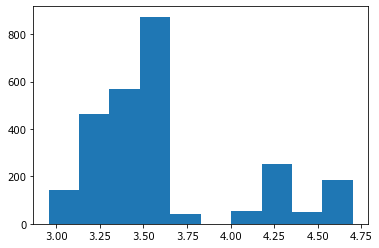

In [22]:
plt.hist(paths)
plt.show()                                                                                            

### Visualize pore size distribution (length in angstrom)

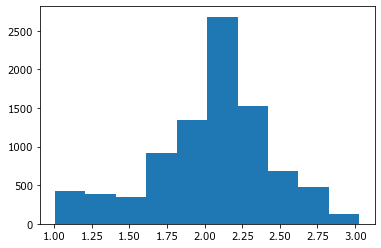

In [23]:
plt.hist(psd)
plt.show()